# Bike Sharing

Supervised Learning. Regression

Daily bike rental ridership prediction using an artificial neural network in Keras

This notebook is based on the [first project](https://github.com/udacity/deep-learning/tree/master/first-neural-network) proposed in the [Deep Learning Nanodegree Foundation of Udacity](https://www.udacity.com/course/deep-learning-nanodegree-foundation--nd101Deep). Original solution with Numpy [Here](https://github.com/angelmtenor/deep-learning/blob/master/first-neural-network/dlnd-your-first-neural-network.ipynb)

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import helper

helper.reproducible(seed=9)
sns.set()

## Load and prepare the data

In [17]:
data_path = 'data/Bike-Sharing-Dataset/hour.csv'
df = pd.read_csv(data_path)
df.head()   

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [18]:
# add day to dataset
ind = pd.to_datetime(df['dteday'])
df['day'] = pd.DatetimeIndex(ind).day
# del df['dteday']

In [19]:
target = ['cnt', 'casual', 'registered']
features = [f for f in list(df) if f not in target]

numerical = ['instant', 'temp', 'atemp', 'hum', 'windspeed'] + target
categorical = [f for f in list(df) if f not in numerical]

### Check out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. We also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. Below is a plot showing the hourly rentals over the first 10 days in the data set. The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week.

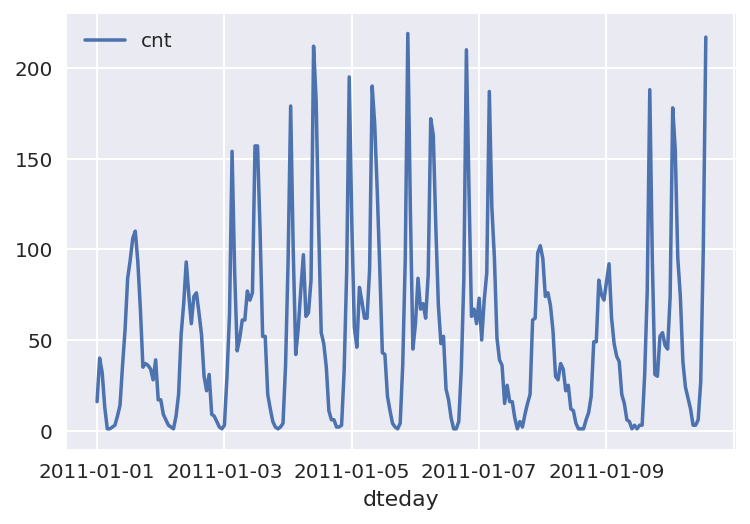

In [20]:
df[:24*10].plot(x='dteday', y='cnt')

In [27]:
df['casual'].describe()

count    17379.000000
mean        35.676218
std         49.305030
min          0.000000
25%          4.000000
50%         17.000000
75%         48.000000
max        367.000000
Name: casual, dtype: float64

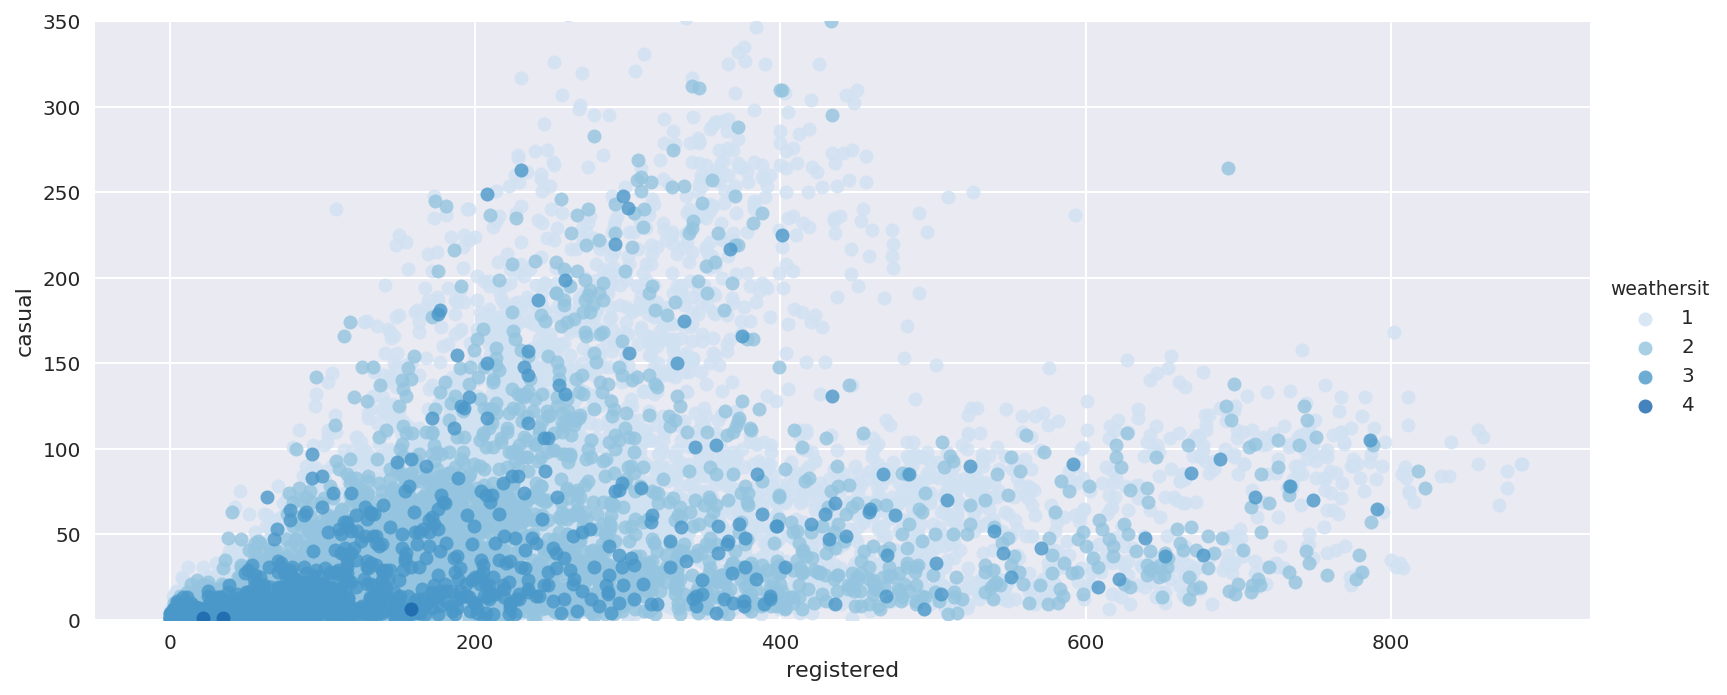

In [51]:
g = sns.PairGrid(df, y_vars='casual', x_vars='registered', size=5, aspect=9/4, 
                 hue = 'weathersit', palette='Blues')
g.map(sns.regplot, fit_reg=False).add_legend()
g.axes[0, 0].set_ylim(0,350);

This plot shows the differences between the number of registered and casual riders for the different weather situations. Most of the riders are registered with very bad weather (`weathersit=4`).

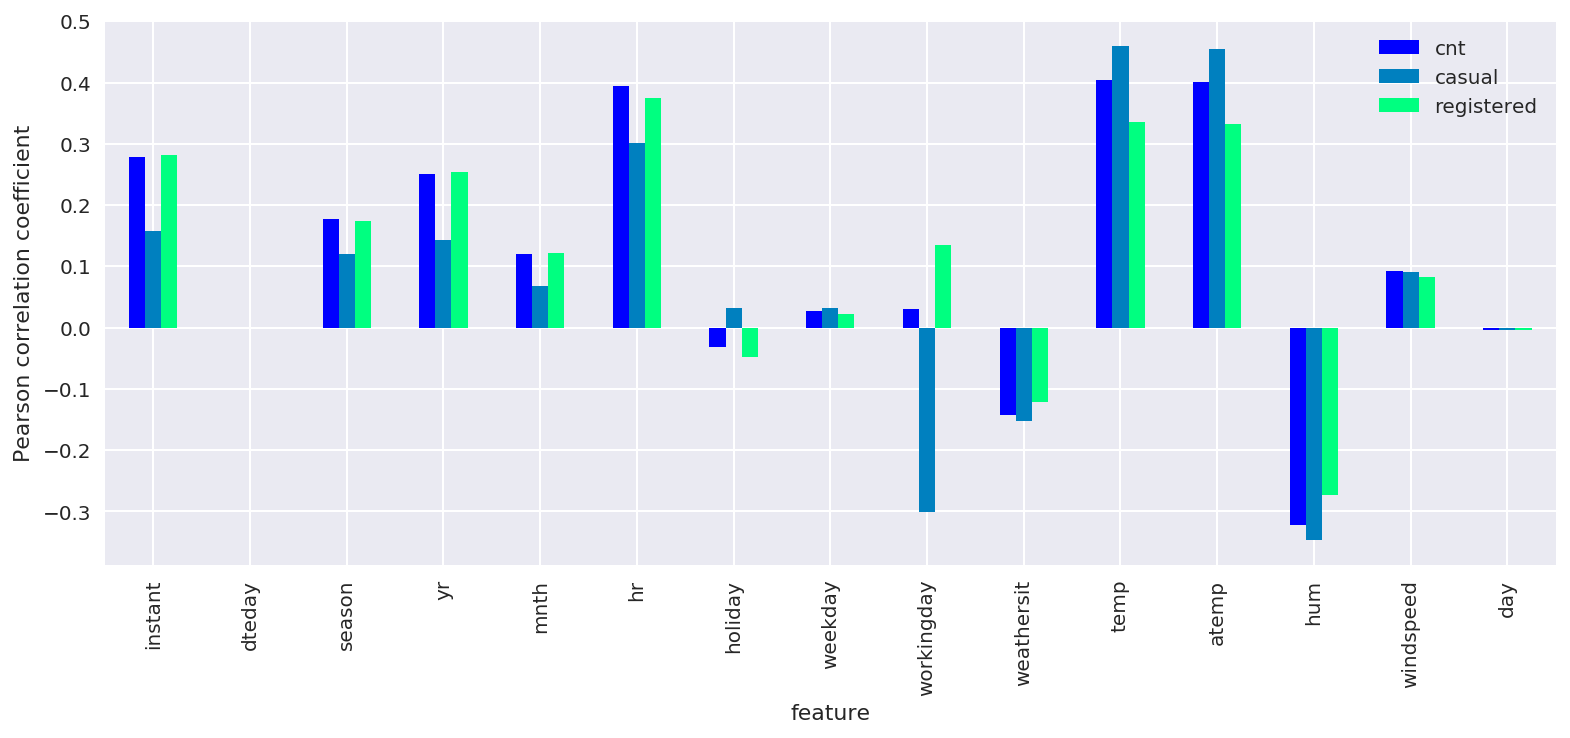

In [81]:
df.corr().reindex(features)[target]
corr.plot.bar(figsize=(13, 5), colormap='winter')
plt.xlabel('feature')
plt.ylabel('Pearson correlation coefficient');

#sns.heatmap(corr, cmap="bwr")

### Select the features

In [82]:
# Remove non-relevant data
drop = ['dteday', 'atemp', 'day']
features = [f for f in features if f not in drop]

# From now use data instead of df
data = df[features + target]
data.head()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,casual,registered
0,1,1,0,1,0,0,6,0,1,0.24,0.81,0.0,16,3,13
1,2,1,0,1,1,0,6,0,1,0.22,0.80,0.0,40,8,32
2,3,1,0,1,2,0,6,0,1,0.22,0.80,0.0,32,5,27
3,4,1,0,1,3,0,6,0,1,0.24,0.75,0.0,13,3,10
4,5,1,0,1,4,0,6,0,1,0.24,0.75,0.0,1,0,1


### Create dummy variables

In [83]:
for field in categorical:
    if field in (features + target):
        dummies = pd.get_dummies(data[field], prefix=field, drop_first=False)
        data = pd.concat([data, dummies], axis=1)
        data.drop(field, axis=1, inplace=True)    

### Scaling numerical variables
Shift and scale the variables such that they have zero mean and a standard deviation of 1. The scaling factors are saved so we can go backwards when we use the network for predictions.

In [84]:
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for field in numerical:
    if field in (features + target):    
        mean, std = data[field].mean(), data[field].std()
        scaled_features[field] = [mean, std]
        data.loc[:, field] = (data[field] - mean)/std

data.head()

,instant,temp,hum,windspeed,cnt,casual,registered,season_1,season_2,season_3,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,-1.731901,-1.334609,0.947345,-1.553844,-0.956312,-0.662736,-0.930162,1,0,0,...,0,0,0,1,1,0,1,0,0,0
1,-1.731702,-1.438475,0.895513,-1.553844,-0.823998,-0.561326,-0.804632,1,0,0,...,0,0,0,1,1,0,1,0,0,0
2,-1.731503,-1.438475,0.895513,-1.553844,-0.868103,-0.622172,-0.837666,1,0,0,...,0,0,0,1,1,0,1,0,0,0
3,-1.731303,-1.334609,0.636351,-1.553844,-0.972851,-0.662736,-0.949983,1,0,0,...,0,0,0,1,1,0,1,0,0,0
4,-1.731104,-1.334609,0.636351,-1.553844,-1.039008,-0.723582,-1.009445,1,0,0,...,0,0,0,1,1,0,1,0,0,0


### Split the data into training, test, and validation sets

In [85]:
# Save the last 21 days as a test set
test_data = data[-21*24:]
train_data = data[:-21*24]

# Separate the data into features and targets
train_features, train_targets = train_data.drop(target, axis=1), train_data[target]
test_features, test_targets = test_data.drop(target, axis=1), test_data[target]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [86]:
# Hold out the last 60 days of the remaining data as a validation set
val_features, val_targets = train_features[-60*24:], train_targets[-60*24:]
train_features, train_targets = train_features[:-60*24], train_targets[:-60*24]

## Neural Network
  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 61)                3782      
_________________________________________________________________
dropout_5 (Dropout)          (None, 61)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 30)                1860      
_________________________________________________________________
dropout_6 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 93        
Total params: 5,735
Trainable params: 5,735
Non-trainable params: 0
_________________________________________________________________
Training ...
CPU times: user 2 s, sys: 72 ms, total: 2.07 s
Wall time: 1.86 s


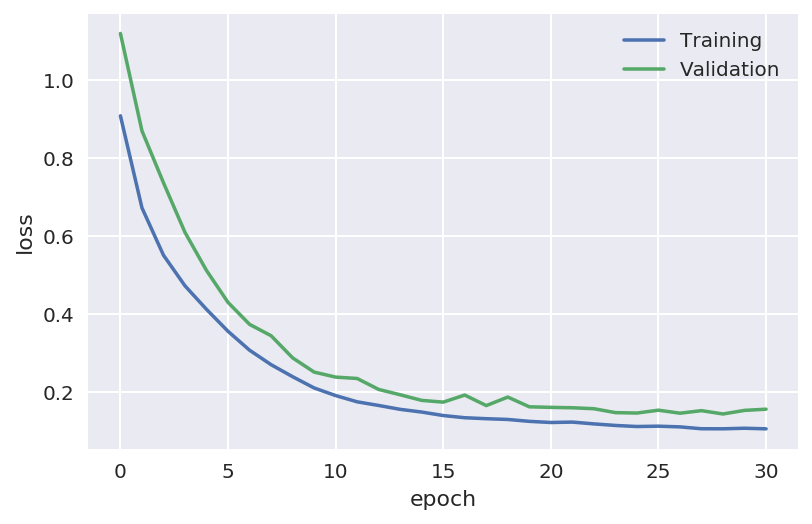


Training loss:  	0.1054
Validation loss: 	0.1558

Model saved at models/bike_sharing.h5


In [88]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
# from keras.layers.advanced_activations import LeakyReLU

train_features = np.array(train_features)
train_targets = np.array(train_targets)
val_features = np.array(val_features)
val_targets = np.array(val_targets)
test_features = np.array(test_features)

n_nodes = train_features.shape[1]

model = Sequential()
model.add(Dense(n_nodes, activation='relu', input_dim = train_features.shape[1]))
model.add(Dropout(.1))
model.add(Dense(n_nodes//2, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(3))
model.summary()

model.compile(loss='mean_squared_error', optimizer='rmsprop')

print("Training ...")
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=0)]
%time history = model.fit(train_features, train_targets, epochs=400, batch_size=1024, verbose=0, validation_data=(val_features, val_targets), callbacks=callbacks)
helper.show_training(history)

model_path = os.path.join("models", "bike_sharing.h5")
model.save(model_path)
print("\nModel saved at",model_path)

### Make predicitons

Model loaded: models/bike_sharing.h5


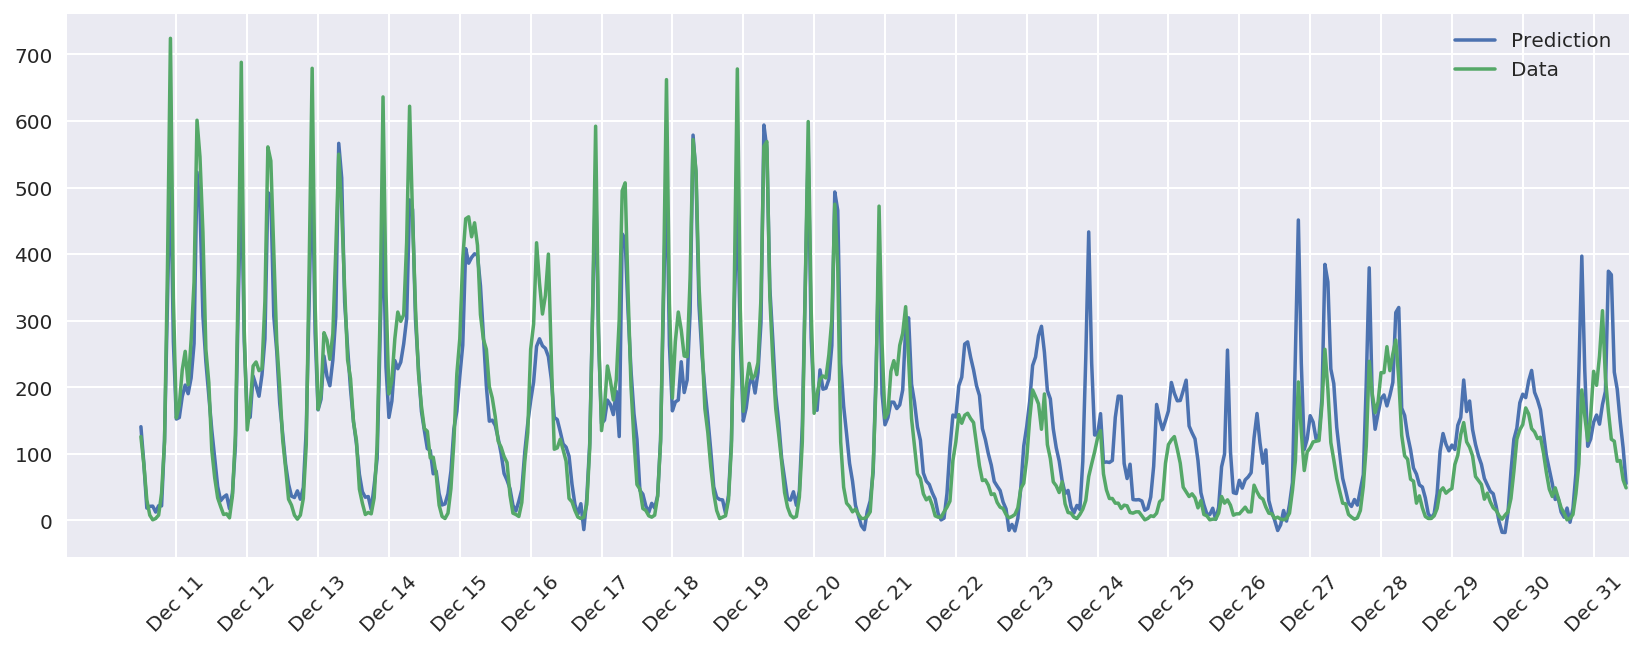

In [89]:
model = keras.models.load_model(model_path)
print("Model loaded:", model_path)

pred = model.predict(test_features)

fig, ax = plt.subplots(figsize=(14,5))

mean, std = scaled_features['cnt']
predictions = pred*std + mean
ax.plot(predictions[:,0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(df.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

The model seems quite accurate considering that only 2 years of data were available. 

It fails on the last 10 days of December: more bike riders were expected.

The model was not trained to predict this drop: the training set included data from December 22 to December 31 just from one year (2011), which is not enough. A small analysis of the dataset and some tests performed with different models led me to the following results and conclusions:

- Adding more features of the dataset to the model has a negligible impact of the accuracy of the model, just makes the network more complex. Removing or replacing the current features makes the model worse.

    
- The training period Dec 22 - Dec 31 in 2011 had more registered riders (mean = 73.6) than the testing one in 2012 (mean = 58.3). The rest of features, such those related with the weather, were able to predict a little drop (Christmas weather in 2012 was a bit worse than in 2011), but not the decline registered at Christmas 2012. One or more new features could help to predict these anomalies, such as including the number of active registrations, or even a boolean 'Christmas' feature.
    
    

    